In [49]:
import numpy as np
import pandas as pd
# settings to display all columns
pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
import seaborn as sns

from category_encoders.count import CountEncoder
from category_encoders.one_hot import OneHotEncoder
from category_encoders.cat_boost import CatBoostEncoder

from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_auc_score, plot_confusion_matrix, plot_roc_curve
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

In [3]:
df = pd.read_csv('data_cleaned.csv')

In [4]:
X = df.drop(columns='non_functional')
y = df['non_functional']

In [5]:
num_cols = []
sm_cat_cols = []
lg_cat_cols = []

for c in X.columns:
    if X[c].dtype in ['float64', 'int64']:
        num_cols.append(c)
    elif X[c].nunique() < 25:
        sm_cat_cols.append(c)
    else:
        lg_cat_cols.append(c)

In [6]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y,
                                                          test_size = .10, random_state = 396)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train,
                                                    test_size = .25, random_state = 396)

In [7]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_holdout.shape, y_holdout.shape

((40070, 22), (40070,), (13357, 22), (13357,), (5937, 22), (5937,))

In [27]:
def evaluate(estimator, X_tr, X_te, y_tr, y_te, cv=5, grid_search=False):
    '''
    
    '''
    if grid_search == False:
        # Cross-Validate
        output = cross_validate(estimator, X_tr, y_tr, cv=cv,
                                scoring=['accuracy', 'precision','recall', 'f1', 'roc_auc'])
        print('Results of Cross-Validation:\n')
        print(f'Average accuracy: {output["test_accuracy"].mean()}\
        +/- {output["test_accuracy"].std()}')
        print(f'Average precision: {output["test_precision"].mean()}\
        +/- {output["test_precision"].std()}')
        print(f'**Average recall: {output["test_recall"].mean()}\
        +/- {output["test_recall"].std()}')
        print(f'Average f1 score: {output["test_f1"].mean()}\
        +/- {output["test_f1"].std()}')
        print(f'Average roc_auc: {output["test_roc_auc"].mean()}\
        +/- {output["test_roc_auc"].std()}\n')
        print('+'*20)
    
        # Test Validate
        estimator.fit(X_tr, y_tr)
        tr_preds = estimator.predict(X_tr)
        te_preds = estimator.predict(X_te)
        categories = ['Functional', 'Non-Functional']
        print('\nResults of Train-Test Split Validation:')
        plot_confusion_matrix(estimator, X_te, y_te, display_labels= categories,
                              cmap='mako')
        print("\nTraining Scores:")
        print(f"Train accuracy: {accuracy_score(y_tr, tr_preds)}")
        print(f"Train precision: {precision_score(y_tr, tr_preds)}")
        print(f"**Train recall: {recall_score(y_tr, tr_preds)}")
        print(f"Train f1 score: {f1_score(y_tr, tr_preds)}")
        print(f"Train roc_auc: {roc_auc_score(y_tr, tr_preds)}\n")
        print("<>"*10)
        print("\nTesting Scores:")
        print(f"Test accuracy: {accuracy_score(y_te, te_preds)}")
        print(f"Test precision: {precision_score(y_te, te_preds)}")
        print(f"**Test recall: {recall_score(y_te, te_preds)}")
        print(f"Test f1 score: {f1_score(y_te, te_preds)}")
        print(f"Test roc_auc: {roc_auc_score(y_te, te_preds)}")
    
    else:
        estimator.fit(X_tr, y_tr)
        tr_preds = estimator.predict(X_tr)
        te_preds = estimator.predict(X_te)
        categories = ['Functional', 'Non-Functional']
        print('\nResults of Train-Test Split Validation:')
        plot_confusion_matrix(estimator, X_te, y_te, display_labels= categories,
                              cmap='mako')
        print("\nTraining Scores:")
        print(f"Train accuracy: {accuracy_score(y_tr, tr_preds)}")
        print(f"Train precision: {precision_score(y_tr, tr_preds)}")
        print(f"**Train recall: {recall_score(y_tr, tr_preds)}")
        print(f"Train f1 score: {f1_score(y_tr, tr_preds)}")
        print(f"Train roc_auc: {roc_auc_score(y_tr, tr_preds)}\n")
        print("<>"*10)
        print("\nTesting Scores:")
        print(f"Test accuracy: {accuracy_score(y_te, te_preds)}")
        print(f"Test precision: {precision_score(y_te, te_preds)}")
        print(f"**Test recall: {recall_score(y_te, te_preds)}")
        print(f"Test f1 score: {f1_score(y_te, te_preds)}")
        print(f"Test roc_auc: {roc_auc_score(y_te, te_preds)}")

### Preprocessing

**NUMERIC COLUMNS**

- (Prob not) Create new t/f columns for construction year and population
- IterativeImputer
    - construction year - 0 doesn't make sense -> nan
    - lat/long 'hidden nans' 
- MinMaxScaler - doesn't assume normal distribution

**CATEGORICAL COLUMNS**
- "Unknown" becomes separate category
- OHE for small
- CountEncoder for large¶



In [9]:
# creating Pipelines for each column type:
# numeric, categorical with under 25 categories, categorical with over 25 categories

num_col_pipe = Pipeline(steps = [
    ('ii', IterativeImputer(random_state=396, add_indicator=True)),
    ('mm', MinMaxScaler())
])

sm_cat_col_pipe = Pipeline(steps = [
    ('ohe', OneHotEncoder(handle_unknown = 'indicator'))
])

lg_cat_col_pipe = Pipeline(steps = [
    ('count', CountEncoder(min_group_size=10, min_group_name='Other'))
])

all_cat_col_pipe = Pipeline(steps = [
    ('catboost', CatBoostEncoder(random_state=396))
])

In [10]:
preprocessor1 = ColumnTransformer(transformers=[
    ('numeric', num_col_pipe, num_cols),
    ('small_cat', sm_cat_col_pipe, sm_cat_cols),
    ('large_cat', lg_cat_col_pipe, lg_cat_cols )
])

preprocessor2 = ColumnTransformer(transformers=[
    ('numeric', num_col_pipe, num_cols),
    ('cat', all_cat_col_pipe, [*sm_cat_cols, *lg_cat_cols]),
])

## Stupid Dummy Idiot Model

C:\Users\Jenny\anaconda3.1\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jenny\anaconda3.1\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jenny\anaconda3.1\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jenny\anaconda3.1\envs\learn-env\lib\site-packages\sklearn

Results of Cross-Validation:

Average accuracy: 0.5431494883953081    +/- 4.9912652857475586e-05
Average precision: 0.0    +/- 0.0
**Average recall: 0.0    +/- 0.0
Average f1 score: 0.0    +/- 0.0
Average roc_auc: 0.5    +/- 0.0

++++++++++++++++++++

Results of Train-Test Split Validation:

Training Scores:
Train accuracy: 0.5431494883953082
Train precision: 0.0
**Train recall: 0.0
Train f1 score: 0.0
Train roc_auc: 0.5

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.5414389458710789
Test precision: 0.0
**Test recall: 0.0
Test f1 score: 0.0
Test roc_auc: 0.5


C:\Users\Jenny\anaconda3.1\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jenny\anaconda3.1\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


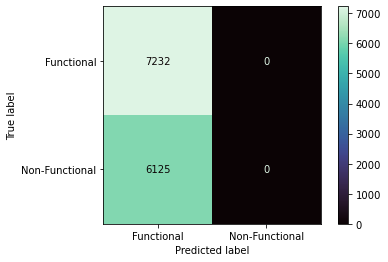

In [13]:
dumbdumbdumb = logreg = Pipeline(steps=[
    ('preprocessor', preprocessor1),
    ('classifier', DummyClassifier(strategy='most_frequent'))
])

evaluate(dumbdumbdumb, X_train, X_test, y_train, y_test, cv=5)

Results of Cross-Validation:

Average accuracy: 0.7380334414774146    +/- 0.003355303608337073
Average precision: 0.7816840050467485    +/- 0.001391321907022129
**Average recall: 0.5918825991591294    +/- 0.009346387430912154
Average f1 score: 0.6736312930418672    +/- 0.0062884167554996045
Average roc_auc: 0.8088226561743662    +/- 0.00710745990250509

++++++++++++++++++++

Results of Train-Test Split Validation:

Training Scores:
Train accuracy: 0.7334664337409533
Train precision: 0.7814853093164034
**Train recall: 0.5782803452419971
Train f1 score: 0.6646992339570513
Train roc_auc: 0.7211379671440642

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.7285318559556787
Test precision: 0.7771124417831005
**Test recall: 0.5720816326530612
Test f1 score: 0.6590182433703217
Test roc_auc: 0.7165579623442297


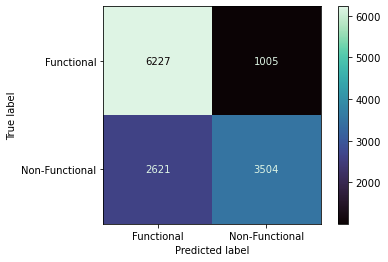

In [14]:
# ~2 minutes
logreg = Pipeline(steps=[
    ('preprocessor', preprocessor1),
    ('classifier', LogisticRegression(random_state=396, max_iter=1000))
])

evaluate(logreg, X_train, X_test, y_train, y_test, cv=5)

Results of Cross-Validation:

Average accuracy: 0.7577738956825555    +/- 0.004950167713787846
Average precision: 0.7337410630172154    +/- 0.007248368655924911
**Average recall: 0.7375178251995923    +/- 0.00692682111960049
Average f1 score: 0.7355908708403478    +/- 0.005007315350745493
Average roc_auc: 0.7561646360021826    +/- 0.0048085443604879465

++++++++++++++++++++

Results of Train-Test Split Validation:

Training Scores:
Train accuracy: 1.0
Train precision: 1.0
**Train recall: 1.0
Train f1 score: 1.0
Train roc_auc: 1.0

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.7583289660851987
Test precision: 0.734726948630692
**Test recall: 0.7402448979591837
Test f1 score: 0.7374756018217308
Test roc_auc: 0.7569449047318042


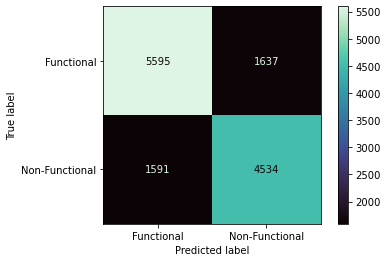

In [15]:
dt = Pipeline(steps=[
    ('preprocessor', preprocessor1),
    ('classifier', DecisionTreeClassifier(random_state=396))
])

evaluate(dt, X_train, X_test, y_train, y_test, cv=5)

Results of Cross-Validation:

Average accuracy: 0.8142001497379585    +/- 0.005237262147072506
Average precision: 0.822432297441831    +/- 0.008215468603354167
**Average recall: 0.7568010101306955    +/- 0.009703850381972872
Average f1 score: 0.7881972882154242    +/- 0.006201610985087064
Average roc_auc: 0.8916793348325548    +/- 0.0030553141410370947

++++++++++++++++++++

Results of Train-Test Split Validation:

Training Scores:
Train accuracy: 1.0
Train precision: 1.0
**Train recall: 1.0
Train f1 score: 1.0
Train roc_auc: 1.0

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.8179980534551171
Test precision: 0.8255199154035954
**Test recall: 0.764734693877551
Test f1 score: 0.7939655903042632
Test roc_auc: 0.8139215504785985


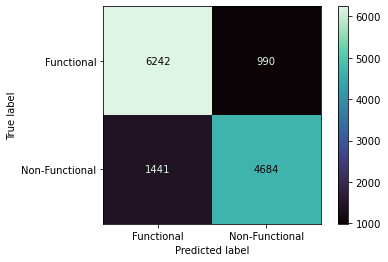

In [18]:
rf1 = Pipeline(steps=[
    ('preprocessor', preprocessor1),
    ('classifier', RandomForestClassifier(random_state=396))
])

evaluate(rf1, X_train, X_test, y_train, y_test, cv=5)

Results of Cross-Validation:

Average accuracy: 0.7950087347142502    +/- 0.0033027319690710423
Average precision: 0.8165740647818529    +/- 0.006102255208584517
**Average recall: 0.711187325747905    +/- 0.01350758929460603
Average f1 score: 0.7601282561956108    +/- 0.005975319721692122
Average roc_auc: 0.8749427338269669    +/- 0.00417489208755837

++++++++++++++++++++

Results of Train-Test Split Validation:

Training Scores:
Train accuracy: 0.8505864736710756
Train precision: 0.8840805636964519
**Train recall: 0.7745001638806949
Train f1 score: 0.8256704423026526
Train roc_auc: 0.8445419400546648

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.8019764917271842
Test precision: 0.8275602409638554
**Test recall: 0.7177142857142857
Test f1 score: 0.7687330593687156
Test roc_auc: 0.7955274968394438


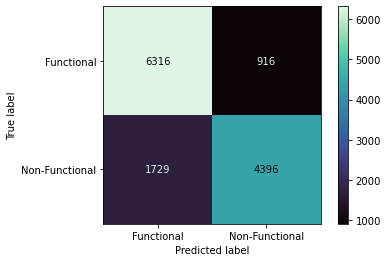

In [19]:
# using CatBoost Encoding
# ~
rf2 = Pipeline(steps=[
    ('preprocessor2', preprocessor2),
    ('classifier', RandomForestClassifier(random_state=396))
])

evaluate(rf2, X_train, X_test, y_train, y_test, cv=5)

Results of Cross-Validation:

Average accuracy: 0.7649613176940354    +/- 0.0028351529167100066
Average precision: 0.7878831707153426    +/- 0.0034131006821104793
**Average recall: 0.6644268912091091    +/- 0.00773969178217303
Average f1 score: 0.7208767982943242    +/- 0.004556990560484588
Average roc_auc: 0.844143274177617    +/- 0.003656754615977581

++++++++++++++++++++

Results of Train-Test Split Validation:

Training Scores:
Train accuracy: 0.7709508360369354
Train precision: 0.7949463616388781
**Train recall: 0.6719654758002841
Train f1 score: 0.7283007696862048
Train roc_auc: 0.7630871304750364

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.7648424047316014
Test precision: 0.7870334744132359
**Test recall: 0.6679183673469388
Test f1 score: 0.7226000176631635
Test roc_auc: 0.7574243385407261


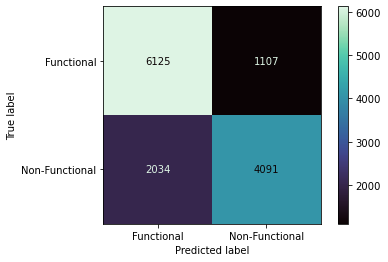

In [20]:
abdt = Pipeline(steps=[
    ('preprocessor', preprocessor1),
    ('classifier', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2),
                                      random_state=396))
])



In [24]:
grid = {'n_estimators': [10,20,30,50,100,200,300,400,500,1000,1500],
        'learning_rate': [.1,.2,.3,.4,.5,.6,.7,.8,.9,1.0,1.5,2.0]
    }

In [25]:
abdt = Pipeline(steps=[
    ('preprocessor', preprocessor1),
    ('classifier', GridSearchCV(estimator=AdaBoostClassifier(), param_grid = grid, verbose = 4))
])

Fitting 5 folds for each of 132 candidates, totalling 660 fits
[CV] learning_rate=0.1, n_estimators=10 ..............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .. learning_rate=0.1, n_estimators=10, score=0.707, total=   0.9s
[CV] learning_rate=0.1, n_estimators=10 ..............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] .. learning_rate=0.1, n_estimators=10, score=0.696, total=   0.9s
[CV] learning_rate=0.1, n_estimators=10 ..............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV] .. learning_rate=0.1, n_estimators=10, score=0.693, total=   0.9s
[CV] learning_rate=0.1, n_estimators=10 ..............................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.5s remaining:    0.0s


[CV] .. learning_rate=0.1, n_estimators=10, score=0.701, total=   0.9s
[CV] learning_rate=0.1, n_estimators=10 ..............................
[CV] .. learning_rate=0.1, n_estimators=10, score=0.698, total=   0.9s
[CV] learning_rate=0.1, n_estimators=20 ..............................
[CV] .. learning_rate=0.1, n_estimators=20, score=0.710, total=   1.7s
[CV] learning_rate=0.1, n_estimators=20 ..............................
[CV] .. learning_rate=0.1, n_estimators=20, score=0.701, total=   1.7s
[CV] learning_rate=0.1, n_estimators=20 ..............................
[CV] .. learning_rate=0.1, n_estimators=20, score=0.695, total=   1.7s
[CV] learning_rate=0.1, n_estimators=20 ..............................
[CV] .. learning_rate=0.1, n_estimators=20, score=0.704, total=   1.7s
[CV] learning_rate=0.1, n_estimators=20 ..............................
[CV] .. learning_rate=0.1, n_estimators=20, score=0.699, total=   1.7s
[CV] learning_rate=0.1, n_estimators=30 ..............................
[CV] .

[CV] .. learning_rate=0.2, n_estimators=20, score=0.709, total=   1.6s
[CV] learning_rate=0.2, n_estimators=20 ..............................
[CV] .. learning_rate=0.2, n_estimators=20, score=0.705, total=   1.6s
[CV] learning_rate=0.2, n_estimators=20 ..............................
[CV] .. learning_rate=0.2, n_estimators=20, score=0.712, total=   1.6s
[CV] learning_rate=0.2, n_estimators=20 ..............................
[CV] .. learning_rate=0.2, n_estimators=20, score=0.711, total=   1.5s
[CV] learning_rate=0.2, n_estimators=30 ..............................
[CV] .. learning_rate=0.2, n_estimators=30, score=0.726, total=   2.3s
[CV] learning_rate=0.2, n_estimators=30 ..............................
[CV] .. learning_rate=0.2, n_estimators=30, score=0.716, total=   2.9s
[CV] learning_rate=0.2, n_estimators=30 ..............................
[CV] .. learning_rate=0.2, n_estimators=30, score=0.714, total=   2.4s
[CV] learning_rate=0.2, n_estimators=30 ..............................
[CV] .

[CV] .. learning_rate=0.3, n_estimators=20, score=0.718, total=   1.6s
[CV] learning_rate=0.3, n_estimators=30 ..............................
[CV] .. learning_rate=0.3, n_estimators=30, score=0.728, total=   2.3s
[CV] learning_rate=0.3, n_estimators=30 ..............................
[CV] .. learning_rate=0.3, n_estimators=30, score=0.721, total=   2.3s
[CV] learning_rate=0.3, n_estimators=30 ..............................
[CV] .. learning_rate=0.3, n_estimators=30, score=0.718, total=   2.3s
[CV] learning_rate=0.3, n_estimators=30 ..............................
[CV] .. learning_rate=0.3, n_estimators=30, score=0.724, total=   2.3s
[CV] learning_rate=0.3, n_estimators=30 ..............................
[CV] .. learning_rate=0.3, n_estimators=30, score=0.724, total=   2.3s
[CV] learning_rate=0.3, n_estimators=50 ..............................
[CV] .. learning_rate=0.3, n_estimators=50, score=0.740, total=   3.9s
[CV] learning_rate=0.3, n_estimators=50 ..............................
[CV] .

[CV] .. learning_rate=0.4, n_estimators=30, score=0.728, total=   2.3s
[CV] learning_rate=0.4, n_estimators=30 ..............................
[CV] .. learning_rate=0.4, n_estimators=30, score=0.725, total=   2.3s
[CV] learning_rate=0.4, n_estimators=30 ..............................
[CV] .. learning_rate=0.4, n_estimators=30, score=0.729, total=   2.3s
[CV] learning_rate=0.4, n_estimators=50 ..............................
[CV] .. learning_rate=0.4, n_estimators=50, score=0.741, total=   4.1s
[CV] learning_rate=0.4, n_estimators=50 ..............................
[CV] .. learning_rate=0.4, n_estimators=50, score=0.732, total=   4.0s
[CV] learning_rate=0.4, n_estimators=50 ..............................
[CV] .. learning_rate=0.4, n_estimators=50, score=0.735, total=   3.9s
[CV] learning_rate=0.4, n_estimators=50 ..............................
[CV] .. learning_rate=0.4, n_estimators=50, score=0.733, total=   3.9s
[CV] learning_rate=0.4, n_estimators=50 ..............................
[CV] .

[CV] .. learning_rate=0.5, n_estimators=50, score=0.746, total=   3.8s
[CV] learning_rate=0.5, n_estimators=50 ..............................
[CV] .. learning_rate=0.5, n_estimators=50, score=0.736, total=   3.8s
[CV] learning_rate=0.5, n_estimators=50 ..............................
[CV] .. learning_rate=0.5, n_estimators=50, score=0.735, total=   3.8s
[CV] learning_rate=0.5, n_estimators=50 ..............................
[CV] .. learning_rate=0.5, n_estimators=50, score=0.737, total=   3.8s
[CV] learning_rate=0.5, n_estimators=50 ..............................
[CV] .. learning_rate=0.5, n_estimators=50, score=0.740, total=   3.8s
[CV] learning_rate=0.5, n_estimators=100 .............................
[CV] . learning_rate=0.5, n_estimators=100, score=0.755, total=   7.6s
[CV] learning_rate=0.5, n_estimators=100 .............................
[CV] . learning_rate=0.5, n_estimators=100, score=0.743, total=   7.6s
[CV] learning_rate=0.5, n_estimators=100 .............................
[CV] .

[CV] .. learning_rate=0.6, n_estimators=50, score=0.740, total=   4.3s
[CV] learning_rate=0.6, n_estimators=50 ..............................
[CV] .. learning_rate=0.6, n_estimators=50, score=0.739, total=   3.9s
[CV] learning_rate=0.6, n_estimators=100 .............................
[CV] . learning_rate=0.6, n_estimators=100, score=0.753, total=   7.7s
[CV] learning_rate=0.6, n_estimators=100 .............................
[CV] . learning_rate=0.6, n_estimators=100, score=0.744, total=   8.0s
[CV] learning_rate=0.6, n_estimators=100 .............................
[CV] . learning_rate=0.6, n_estimators=100, score=0.739, total=   8.6s
[CV] learning_rate=0.6, n_estimators=100 .............................
[CV] . learning_rate=0.6, n_estimators=100, score=0.747, total=   8.0s
[CV] learning_rate=0.6, n_estimators=100 .............................
[CV] . learning_rate=0.6, n_estimators=100, score=0.745, total=   7.6s
[CV] learning_rate=0.6, n_estimators=200 .............................
[CV] .

[CV] . learning_rate=0.7, n_estimators=100, score=0.743, total=   7.7s
[CV] learning_rate=0.7, n_estimators=100 .............................
[CV] . learning_rate=0.7, n_estimators=100, score=0.742, total=   7.7s
[CV] learning_rate=0.7, n_estimators=100 .............................
[CV] . learning_rate=0.7, n_estimators=100, score=0.750, total=   7.6s
[CV] learning_rate=0.7, n_estimators=100 .............................
[CV] . learning_rate=0.7, n_estimators=100, score=0.747, total=   7.6s
[CV] learning_rate=0.7, n_estimators=200 .............................
[CV] . learning_rate=0.7, n_estimators=200, score=0.758, total=  15.3s
[CV] learning_rate=0.7, n_estimators=200 .............................
[CV] . learning_rate=0.7, n_estimators=200, score=0.752, total=  15.4s
[CV] learning_rate=0.7, n_estimators=200 .............................
[CV] . learning_rate=0.7, n_estimators=200, score=0.748, total=  15.9s
[CV] learning_rate=0.7, n_estimators=200 .............................
[CV] .

[CV] . learning_rate=0.8, n_estimators=100, score=0.745, total=   7.6s
[CV] learning_rate=0.8, n_estimators=200 .............................
[CV] . learning_rate=0.8, n_estimators=200, score=0.757, total=  15.4s
[CV] learning_rate=0.8, n_estimators=200 .............................
[CV] . learning_rate=0.8, n_estimators=200, score=0.752, total=  17.1s
[CV] learning_rate=0.8, n_estimators=200 .............................
[CV] . learning_rate=0.8, n_estimators=200, score=0.747, total=  15.3s
[CV] learning_rate=0.8, n_estimators=200 .............................
[CV] . learning_rate=0.8, n_estimators=200, score=0.758, total=  15.5s
[CV] learning_rate=0.8, n_estimators=200 .............................
[CV] . learning_rate=0.8, n_estimators=200, score=0.751, total=  15.5s
[CV] learning_rate=0.8, n_estimators=300 .............................
[CV] . learning_rate=0.8, n_estimators=300, score=0.760, total=  23.1s
[CV] learning_rate=0.8, n_estimators=300 .............................
[CV] .

[CV] . learning_rate=0.9, n_estimators=200, score=0.755, total=  15.4s
[CV] learning_rate=0.9, n_estimators=200 .............................
[CV] . learning_rate=0.9, n_estimators=200, score=0.758, total=  15.3s
[CV] learning_rate=0.9, n_estimators=200 .............................
[CV] . learning_rate=0.9, n_estimators=200, score=0.751, total=  15.2s
[CV] learning_rate=0.9, n_estimators=300 .............................
[CV] . learning_rate=0.9, n_estimators=300, score=0.761, total=  22.9s
[CV] learning_rate=0.9, n_estimators=300 .............................
[CV] . learning_rate=0.9, n_estimators=300, score=0.756, total=  23.6s
[CV] learning_rate=0.9, n_estimators=300 .............................
[CV] . learning_rate=0.9, n_estimators=300, score=0.755, total=  22.9s
[CV] learning_rate=0.9, n_estimators=300 .............................
[CV] . learning_rate=0.9, n_estimators=300, score=0.760, total=  23.1s
[CV] learning_rate=0.9, n_estimators=300 .............................
[CV] .

[CV] . learning_rate=1.0, n_estimators=300, score=0.762, total=  23.6s
[CV] learning_rate=1.0, n_estimators=300 .............................
[CV] . learning_rate=1.0, n_estimators=300, score=0.755, total=  22.9s
[CV] learning_rate=1.0, n_estimators=300 .............................
[CV] . learning_rate=1.0, n_estimators=300, score=0.755, total=  23.0s
[CV] learning_rate=1.0, n_estimators=300 .............................
[CV] . learning_rate=1.0, n_estimators=300, score=0.759, total=  22.9s
[CV] learning_rate=1.0, n_estimators=300 .............................
[CV] . learning_rate=1.0, n_estimators=300, score=0.753, total=  22.9s
[CV] learning_rate=1.0, n_estimators=400 .............................
[CV] . learning_rate=1.0, n_estimators=400, score=0.761, total=  31.5s
[CV] learning_rate=1.0, n_estimators=400 .............................
[CV] . learning_rate=1.0, n_estimators=400, score=0.758, total=  30.7s
[CV] learning_rate=1.0, n_estimators=400 .............................
[CV] .

[CV] . learning_rate=1.5, n_estimators=300, score=0.757, total=  22.9s
[CV] learning_rate=1.5, n_estimators=300 .............................
[CV] . learning_rate=1.5, n_estimators=300, score=0.760, total=  25.0s
[CV] learning_rate=1.5, n_estimators=400 .............................
[CV] . learning_rate=1.5, n_estimators=400, score=0.763, total=  30.4s
[CV] learning_rate=1.5, n_estimators=400 .............................
[CV] . learning_rate=1.5, n_estimators=400, score=0.765, total=  31.6s
[CV] learning_rate=1.5, n_estimators=400 .............................
[CV] . learning_rate=1.5, n_estimators=400, score=0.760, total=  30.6s
[CV] learning_rate=1.5, n_estimators=400 .............................
[CV] . learning_rate=1.5, n_estimators=400, score=0.760, total=  31.2s
[CV] learning_rate=1.5, n_estimators=400 .............................
[CV] . learning_rate=1.5, n_estimators=400, score=0.762, total=  30.5s
[CV] learning_rate=1.5, n_estimators=500 .............................
[CV] .

[CV] . learning_rate=2.0, n_estimators=400, score=0.457, total=  30.9s
[CV] learning_rate=2.0, n_estimators=400 .............................
[CV] . learning_rate=2.0, n_estimators=400, score=0.543, total=  31.4s
[CV] learning_rate=2.0, n_estimators=400 .............................
[CV] . learning_rate=2.0, n_estimators=400, score=0.457, total=  30.9s
[CV] learning_rate=2.0, n_estimators=400 .............................
[CV] . learning_rate=2.0, n_estimators=400, score=0.457, total=  30.8s
[CV] learning_rate=2.0, n_estimators=500 .............................
[CV] . learning_rate=2.0, n_estimators=500, score=0.648, total=  40.9s
[CV] learning_rate=2.0, n_estimators=500 .............................
[CV] . learning_rate=2.0, n_estimators=500, score=0.457, total=  38.5s
[CV] learning_rate=2.0, n_estimators=500 .............................
[CV] . learning_rate=2.0, n_estimators=500, score=0.543, total=  38.4s
[CV] learning_rate=2.0, n_estimators=500 .............................
[CV] .

[Parallel(n_jobs=1)]: Done 660 out of 660 | elapsed: 317.6min finished



Results of Train-Test Split Validation:

Training Scores:
Train accuracy: 0.7809333666084353
Train precision: 0.8041757119141872
**Train recall: 0.6880257838959903
Train f1 score: 0.741580310880829
Train roc_auc: 0.773552498637942

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.7653664745077488
Test precision: 0.788316946211683
**Test recall: 0.6675918367346939
Test f1 score: 0.7229490806223479
Test roc_auc: 0.7578833077478779


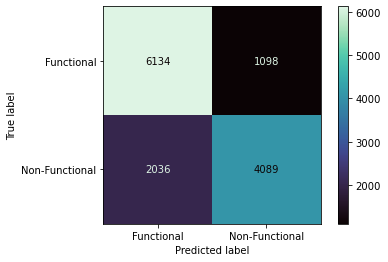

In [28]:
evaluate(abdt, X_train, X_test, y_train, y_test, cv=5, grid_search=True)

In [ ]:
gs_pipe = GridSearchCV(estimator=test_model_loop, param_grid=x['params'])
gs_pipe.fit(X,y)
print('Best Params: {}'.format(gs_pipe.best_params_))
print('Best Score: {}'.format(gs_pipe.best_score_))

Results of Cross-Validation:

Average accuracy: 0.762415772398303        +/- 0.0018825078278658569
Average precision: 0.8267894062742605        +/- 0.0039809113346007605
**Average recall: 0.6072316418905281        +/- 0.009191904976366565
Average f1 score: 0.7001369462955667        +/- 0.004755138840553626
Average roc_auc: 0.8419948152697666        +/- 0.0028906921053404398

++++++++++++++++++++

Results of Train-Test Split Validation:

Training Scores:
Train accuracy: 0.7697529323683554
Train precision: 0.8385533184190902
**Train recall: 0.6142794712116246
Train f1 score: 0.7091058141001386
Train roc_auc: 0.7574016359917708

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.7655162087295051
Test precision: 0.8333704611271998
**Test recall: 0.6107755102040816
Test f1 score: 0.7049180327868853
Test roc_auc: 0.7536731533321294


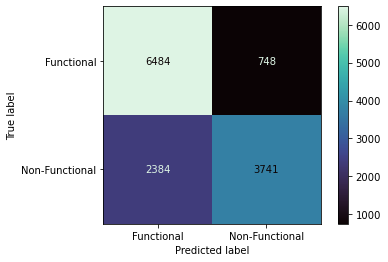

In [44]:
gbc = Pipeline(steps=[
    ('preprocessor1', preprocessor1),
    ('classifier', GradientBoostingClassifier())
])

evaluate(gbc, X_train, X_test, y_train, y_test, cv=5)

Results of Cross-Validation:

Average accuracy: 0.762415772398303        +/- 0.0018825078278658569
Average precision: 0.8267894062742605        +/- 0.0039809113346007605
**Average recall: 0.6072316418905281        +/- 0.009191904976366565
Average f1 score: 0.7001369462955667        +/- 0.004755138840553626
Average roc_auc: 0.8419993832498782        +/- 0.0028972778275312234

++++++++++++++++++++

Results of Train-Test Split Validation:

Training Scores:
Train accuracy: 0.7697529323683554
Train precision: 0.8385533184190902
**Train recall: 0.6142794712116246
Train f1 score: 0.7091058141001386
Train roc_auc: 0.7574016359917708

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.7655162087295051
Test precision: 0.8333704611271998
**Test recall: 0.6107755102040816
Test f1 score: 0.7049180327868853
Test roc_auc: 0.7536731533321294


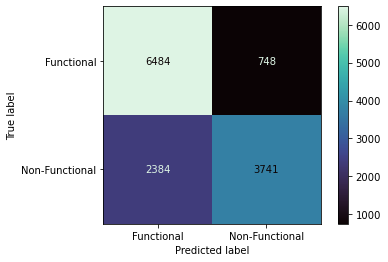

In [46]:
gbc2 = Pipeline(steps=[
    ('preprocessor1', preprocessor1),
    ('classifier', GradientBoostingClassifier(loss = 'exponential'))
])

evaluate(gbc, X_train, X_test, y_train, y_test, cv=5)

In [51]:
ada = Pipeline(steps=[
    ('preprocessor', preprocessor1),
    ('classifier', AdaBoostClassifier())
])

In [52]:
rndfor = Pipeline(steps=[
    ('preprocessor', preprocessor1),
    ('classifier', RandomForestClassifier(random_state=396))
])

In [65]:
X_train_fix = preprocessor1.fit_transform(X_train)

In [84]:
w_avg = VotingClassifier(estimators=[
    ('ada', ada),
    ('rndfor', rndfor)],
    weights=[0.25, 0.75], voting = 'soft')



In [85]:
w_avg.fit(X_test, y_test)

VotingClassifier(estimators=[('ada',
                              Pipeline(steps=[('preprocessor',
                                               ColumnTransformer(transformers=[('numeric',
                                                                                Pipeline(steps=[('ii',
                                                                                                 IterativeImputer(add_indicator=True,
                                                                                                                  random_state=396)),
                                                                                                ('mm',
                                                                                                 MinMaxScaler())]),
                                                                                ['id',
                                                                                 'amount_tsh',
                                     

Results of Cross-Validation:

Average accuracy: 0.8142001497379585        +/- 0.004936686874175866
Average precision: 0.821403812491703        +/- 0.007882623309211769
**Average recall: 0.7582758976150669        +/- 0.009871582934756817
Average f1 score: 0.7885196041794641        +/- 0.005937691580718028
Average roc_auc: 0.8920676199667614        +/- 0.003008595319623302

++++++++++++++++++++

Results of Train-Test Split Validation:

Training Scores:
Train accuracy: 1.0
Train precision: 1.0
**Train recall: 1.0
Train f1 score: 1.0
Train roc_auc: 1.0

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.8180729205659953
Test precision: 0.8238387379491674
**Test recall: 0.7673469387755102
Test f1 score: 0.7945900253592562
Test roc_auc: 0.814190615405454


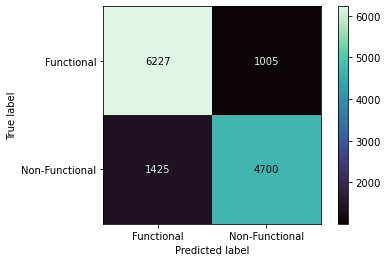

In [87]:
evaluate(w_avg, X_train, X_test, y_train, y_test, cv=5)

In [ ]:
test_dict = {'dec_tree':KNeighborsClassifier(), 'lr':LogisticRegression()}

def basic_model_tests(X, y, test_dict):
    '''Takes in X and y data as well as dictionary of name:test entries to run'''
    scores = []
    for key, value in test_dict.items():
        test_model_loop = Pipeline(steps=[
            (key, value)
        ])
        test_model_loop.fit(X, y)
        score = test_model_loop.score(X, y)
        scores.append({'name':key, 'type':value, 'score':score})
    return scores

In [ ]:
test_list = [{'name':'knn', 'type': KNeighborsClassifier(), 'params':{'knn__n_neighbors': [3, 5, 7], 'knn__p': [1, 2, 3]}},
            {'name': 'lr', 'type': LogisticRegression(), 'params':{'lr__fit_intercept':[False], 'lr__C':[1, 1000, 1e12],
                                                                  'lr__solver':['liblinear','newton-cg', 'lbfgs']}}]
#fit_intercept=False, C= 1e12, solver='liblinear'

In [ ]:
def model_tests(X, y, test_list):
    '''Takes in X and y data as well as a list of dictionaries'''
    scores = []
    for x in test_list:
        test_model_loop = Pipeline(steps=[
            (x['name'], x['type'])
        ])
        test_model_loop.fit(X, y)
#         score = test_model_loop.score(X, y)
#         scores.append({'name':x['name'], 'type':x['type'], 'score':score})
        
        gs_pipe = GridSearchCV(estimator=test_model_loop, param_grid=x['params'])
        gs_pipe.fit(X,y)
        scores.append(gs_pipe.cv_results_)
    return scores